### Importing modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

### Loading data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploratory data analysis

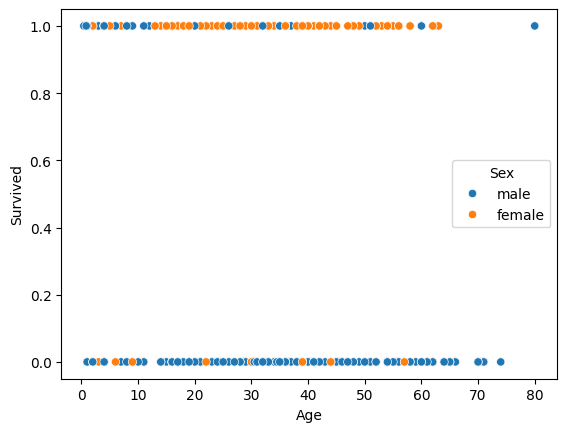

In [4]:
sns.scatterplot(df_train, x='Age', y='Survived', hue='Sex')
plt.show()

In the survived class, the majority seems to be female.

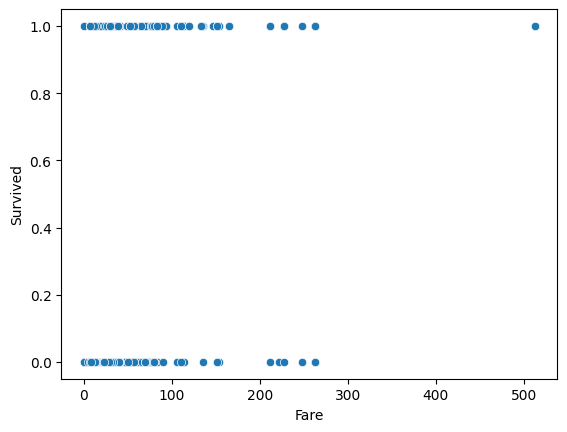

In [5]:
sns.scatterplot(df_train, x='Fare', y='Survived')
plt.show()

There seems to be a slight tendency that people who paid more for the fare tend to survive.

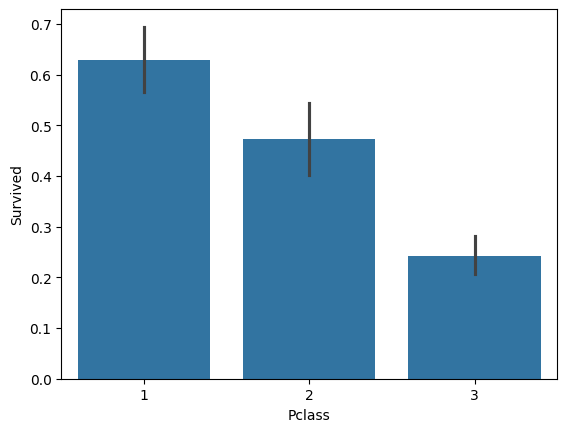

In [6]:
sns.barplot(df_train, x='Pclass', y='Survived')
plt.show()

Passenger class has a clear influence on the survival rate of a passenger.

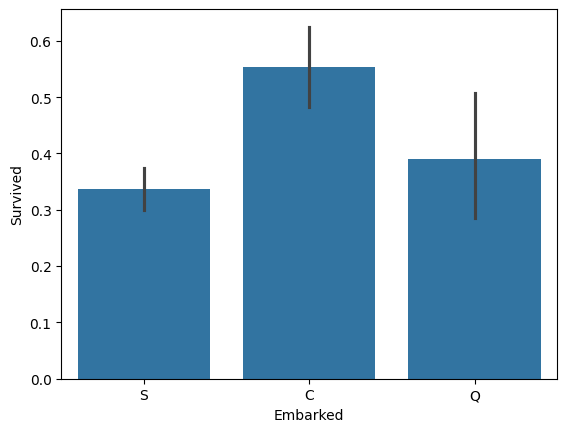

In [7]:
sns.barplot(df_train, x='Embarked', y='Survived')
plt.show()

There also seems to be a dependency on where the passenger embarked on the survival rate.

### Feature engineering

We can use the cabin feature to extract on which deck the passenger stayed. We first take a look at the unique entries to get a sense of the number of decks.

In [8]:
df_train['Cabin'].unique()
print(df_train['Cabin'].unique()[0])

nan


In [9]:
# Create a set to get rid of duplicate entries in the list
cabins = list(set([string[0] for string in df_train['Cabin'].dropna()]))
cabins

['C', 'B', 'A', 'E', 'D', 'G', 'T', 'F']

In [10]:
def substrings_in_string(full_string, substring_list):
    for substring in substring_list:
        # full_string can be float (np.nan), which causes the if statement to fail
        try:
            if substring in full_string:
                return substring
        except TypeError:
            return 'Unknown'
    return 'Unknown'

df_train['Deck'] = df_train['Cabin'].map(lambda string: substrings_in_string(string, cabins))
df_test['Deck'] = df_test['Cabin'].map(lambda string: substrings_in_string(string, cabins))
df_train['Deck'].value_counts()

Deck
Unknown    687
C           59
B           47
E           33
D           33
A           15
F            9
G            7
T            1
Name: count, dtype: int64

df['Deck']=df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

### Preprocess to get training / testing set

In [11]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Deck             0
dtype: int64

In [12]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Deck             0
dtype: int64

In [13]:
mean_age = df_train['Age'].mean()
mean_fare = df_train['Fare'].mean()
mode_embarked = df_train['Embarked'].mode()[0]

for df in [df_train, df_test]:
    df.loc[:, 'Age'] = df['Age'].replace(np.nan, mean_age)
    df.loc[:, 'Fare'] = df['Fare'].replace(np.nan, mean_fare)
    df.loc[:, 'Embarked'] = df['Embarked'].replace(np.nan, mode_embarked)

print(df_train.isnull().sum())
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Deck             0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Deck             0
dtype: int64


In [14]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck']
target = 'Survived'

y = df_train[target]
X = pd.get_dummies(df_train[features], drop_first=True)
X_test = pd.get_dummies(df_test[features], drop_first=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [15]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

print(f'{X_train.shape = }, {X_val.shape = }, {X_test.shape = }')
print(f'{X_train.columns = }')
print(f'{X_val.columns = }')
print(f'{X_test.columns = }')

# One column in the training set is not present in the test set (Deck_T), manually add it and align the columns
X_test['Deck_T'] = 0
X_train, X_test = X_train.align(X_test, axis=1)
print(f'{X_test.shape = }')
print(f'{X_test.columns = }')


X_train.shape = (712, 16), X_val.shape = (179, 16), X_test.shape = (418, 15)
X_train.columns = Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_Unknown'],
      dtype='object')
X_val.columns = Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_Unknown'],
      dtype='object')
X_test.columns = Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_Unknown'],
      dtype='object')
X_test.shape = (418, 16)
X_test.columns = Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_Unknown'],
      dtyp

In [16]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

### Building models

KNN

In [17]:
knn = KNeighborsClassifier()
parameters_knn = {'n_neighbors': np.arange(3, 20, 2),
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn_cv = GridSearchCV(knn, parameters_knn).fit(X_train, y_train)
y_hat_knn = knn_cv.predict(X_val)

In [18]:
knn_accuracy = accuracy_score(y_val, y_hat_knn)
knn_jaccard = jaccard_score(y_val, y_hat_knn)
knn_f1 = f1_score(y_val, y_hat_knn)

print(classification_report(y_val, y_hat_knn))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       106
           1       0.79      0.67      0.73        73

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



Logistic regression

In [19]:
lr = LogisticRegression()
parameters_lr = {'C': np.logspace(-3, 2),
              'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'sag']}

lr_cv = GridSearchCV(lr, parameters_lr).fit(X_train, y_train)
y_hat_lr = lr_cv.predict(X_val)

c:\Users\Stijn\Documents\Kaggle competitions\kaggle\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Stijn\Documents\Kaggle competitions\kaggle\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Stijn\Documents\Kaggle competitions\kaggle\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Stijn\Documents\Kaggle competitions\kaggle\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Stijn\Documents\Kaggle competitions\kaggle\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

In [20]:
lr_accuracy = accuracy_score(y_val, y_hat_lr)
lr_jaccard = jaccard_score(y_val, y_hat_lr)
lr_f1 = f1_score(y_val, y_hat_lr)

print(classification_report(y_val, y_hat_lr))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       106
           1       0.75      0.67      0.71        73

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.78      0.77       179



SVM

In [21]:
svm = SVC()
parameters_svm = {'C': np.logspace(-3, 2),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svm_cv = GridSearchCV(svm, parameters_svm).fit(X_train, y_train)
y_hat_svm = svm_cv.predict(X_val)

In [22]:
svm_accuracy = accuracy_score(y_val, y_hat_svm)
svm_jaccard = jaccard_score(y_val, y_hat_svm)
svm_f1 = f1_score(y_val, y_hat_svm)

print(classification_report(y_val, y_hat_svm))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       106
           1       0.73      0.70      0.71        73

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



Random forest

In [24]:
forest = RandomForestClassifier()
parameters_forest = {'criterion': ['gini', 'entropy', 'log_loss'],
                     'max_depth': np.arange(5, 15),
                     'max_features': ['sqrt', 'log2'],
                     'ccp_alpha': np.append([0], np.logspace(-3, 0))}

forest_cv = GridSearchCV(forest, parameters_forest).fit(X_train, y_train)
y_hat_forest = forest_cv.predict(X_val)

In [25]:
forest_accuracy = accuracy_score(y_val, y_hat_forest)
forest_jaccard = jaccard_score(y_val, y_hat_forest)
forest_f1 = f1_score(y_val, y_hat_forest)

print(classification_report(y_val, y_hat_forest))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       106
           1       0.82      0.70      0.76        73

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



In [26]:
forest_predictor = forest_cv.best_estimator_
forest_predictor

RandomForestClassifier(ccp_alpha=0.0026826957952797246, criterion='log_loss',
                       max_depth=6, max_features='log2')

### Evaluation

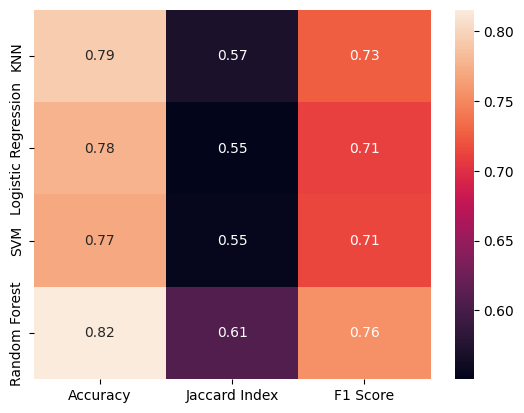

In [27]:
df_results = pd.DataFrame({'Accuracy': [knn_accuracy, lr_accuracy, svm_accuracy, forest_accuracy],
                           'Jaccard Index': [knn_jaccard, lr_jaccard, svm_jaccard, forest_jaccard],
                           'F1 Score': [knn_f1, lr_f1, svm_f1, forest_f1]}, index=['KNN', 'Logistic Regression', 'SVM', 'Random Forest'])

sns.heatmap(df_results, annot=True)
plt.show()

### Best model predictions

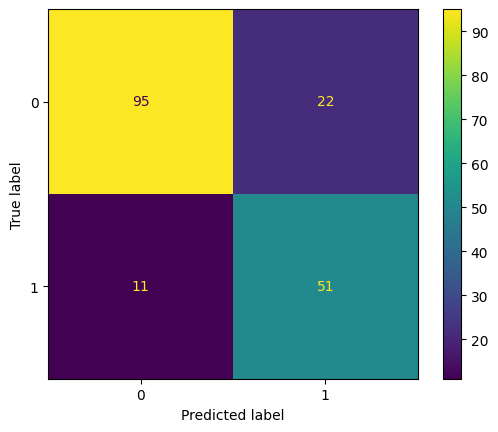

In [33]:
model = forest_cv.best_estimator_
y_test = model.predict(X_test)

confusion_mat = confusion_matrix(model.predict(X_val), y_val)
display = ConfusionMatrixDisplay(confusion_mat)
display.plot()
plt.show()

output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_test})
output.to_csv('output.csv', index=False)